<a href="https://colab.research.google.com/github/chitrashukla/QAN6G24SnT/blob/main/S2_Final_1_R%3D10000_C_%3D_75_Q%3D25_mem_capacity%3D100_TD%3D105_elastic_demand_avg_(1)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
M = 10000 # number of averages
C = 75*1024 # capacity of classical channel bits/s
Q = 25*1024 # quantum capacity of quantum channel qubits/s
mem_capacity = 100*1024 # qubit capacity of quantum memory
stored_ent = 0 # amount of stored entanglement, initiated at 0

# generating time-varying demand
t = np.linspace(1,1440, 1440) # seconds in a day
λ = 100*1024 + 1024*5*np.sin(2*np.pi*3*t/t[-1]) # new comment from Chitra

c_comm_v = [] # classical communication bits in a given second
q_comm_v = [] # quantum communication bits in a given second
e_comm_v = [] # entanglement distribution bits in a given second
sdc_comm_v = [] # communicated bits with superdense coding in a given second
dropped_bits_v = [] # dropped bits in a given second
ent_in_store_v = [] # available entanglement each second
traffic_demand_v = [] # traffic demand

for jj in range(M):
    # will need to take statistical average for runs, currently just generating base logic
    traffic_demand = np.random.poisson(λ)
    c_comm = [] # classical communication bits in a given second
    q_comm = [] # quantum communication bits in a given second
    e_comm = [] # entanglement distribution bits in a given second
    sdc_comm = [] # communicated bits with superdense coding in a given second
    dropped_bits = [] # dropped bits in a given second
    ent_in_store = [] # available entanglement each second
    for ii in range(len(traffic_demand)):
        curr_demand = traffic_demand[ii]
        if curr_demand <= C: # demand less than the classical capacity
            c_comm.append(curr_demand)
            curr_demand = 0 # all demand met on classical channel
            if stored_ent <= mem_capacity:
                e_comm.append(Q) # all quantum bits used for entanglement sharing **** slight error in logic
                stored_ent = np.min([Q+stored_ent, mem_capacity]) # ebits stored in memory
            q_comm.append(0) # no qubit communication
            sdc_comm.append(0) # no SDC performed
            ent_in_store.append(stored_ent)
            dropped_bits.append(0) # nothing dropped

        elif curr_demand <= C + Q: # demand can be met with classical + data qubits
            c_comm.append(C) # need to use all classical slots, at least
            curr_demand -= C # remaining demand
            q_comm.append(curr_demand) # communicating remaining demand with qubits
            if stored_ent <= mem_capacity:
                e_comm.append(Q-curr_demand) # leftover quantum slots used for entanglement sharing **** slight error in logic but we can assume refreshing all memory slots whenever possible
                stored_ent = np.min([Q-curr_demand+stored_ent, mem_capacity]) # ebits stored in memory
            sdc_comm.append(0) # no SDC performed
            ent_in_store.append(stored_ent)
            dropped_bits.append(0) # nothing dropped

        else: # going to SDC
            c_comm.append(C) # need to use all classical slots, at least
            curr_demand -= C # remaining demand
            sdc_cap = np.min([2*Q, 2*stored_ent]) # superdense coding available capacity
            if curr_demand <= sdc_cap: # remaining demand can be met with SDC
                sdc_comm.append(curr_demand - curr_demand%2) # even bits communicated with sdc
                q_comm.append(curr_demand%2) # if lone bit remaining, it is sent by qubit transmission
                if stored_ent <= mem_capacity:
                    e_comm.append(Q - np.ceil(curr_demand)) # any remaining slots for entanglement distribution **** slight error in logic
                    stored_ent = np.min([Q-curr_demand+stored_ent, mem_capacity]) # ebits stored in memory
                ent_in_store.append(stored_ent)
                dropped_bits.append(0) # nothing dropped
                #q_comm.append(0) # no direct qubit transmission
            elif curr_demand <= sdc_cap + (Q - sdc_cap/2): # demand less than what can be done by SDC + classical + Q,
                sdc_comm.append(sdc_cap) # sdc performed completely
                q_comm.append(Q - sdc_cap/2) # remaining slots used for quantum communication
                stored_ent -= sdc_cap/2 # entanglement only consumed, nothing generated
                ent_in_store.append(stored_ent)
                e_comm.append(0)
                dropped_bits.append(0)
            else:
                sdc_comm.append(sdc_cap) # sdc performed completely
                q_comm.append(Q - sdc_cap/2) # remaining slots used for quantum communication
                stored_ent -= sdc_cap/2 # entanglement only consumed, nothing generated
                ent_in_store.append(stored_ent)
                e_comm.append(0)
                dropped_bits.append(curr_demand - sdc_cap - Q + sdc_cap/2)

    c_comm_v.append(c_comm) # classical communication bits in a given second
    q_comm_v.append(q_comm) # quantum communication bits in a given second
    e_comm_v.append(e_comm) # entanglement distribution bits in a given second
    sdc_comm_v.append(sdc_comm) # communicated bits with superdense coding in a given second
    dropped_bits_v.append(dropped_bits) # dropped bits in a given second
    ent_in_store_v.append(ent_in_store) # available entanglement each second
    traffic_demand_v.append(traffic_demand) # traffic demand

traff_mean = np.mean(traffic_demand_v, axis = 0)
traff_std = np.std(traffic_demand_v, axis = 0)

class_comm_mean = np.mean(c_comm_v, axis = 0)
class_comm_std = np.std(c_comm_v, axis = 0)

quant_comm_mean = np.mean(q_comm_v, axis = 0)
quant_comm_std = np.std(q_comm_v, axis = 0)

ent_store_mean = np.mean(ent_in_store_v, axis = 0)
ent_store_std = np.std(ent_in_store_v, axis = 0)

dropp_mean = np.mean(dropped_bits_v, axis = 0)
dropp_std = np.std(dropped_bits_v, axis = 0)

sdc_mean = np.mean(sdc_comm_v, axis = 0)
sdc_std = np.std(sdc_comm_v, axis = 0)

ent_comm_mean = np.mean(e_comm_v, axis = 0)
ent_comm_std = np.std(e_comm_v, axis = 0)




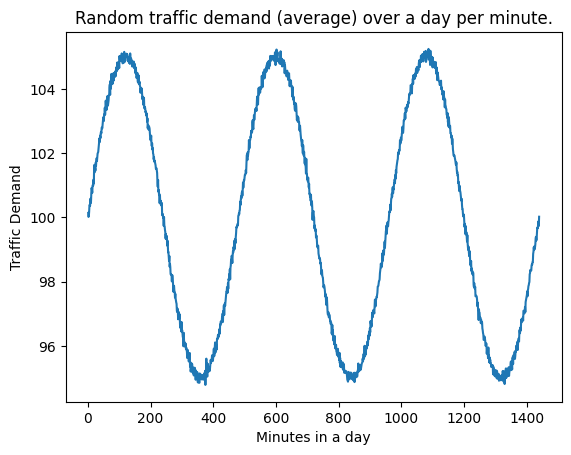

In [ ]:
plt.plot(t, traff_mean)
plt.title('Random traffic demand (average) over a day per minute.') #title of the plot
plt.xlabel('Minutes in a day') # Label for x-axis
plt.ylabel('Traffic Demand') # Label for y-axis

plt.savefig('Traffic Demand_1.png', dpi=300) #save as png for high resolution
#plt.legend()  # Show legend
plt.show()


#Trafic demand high    -- Morning and Evening peak hours (8-10 AM and 5-7 PM respectively) when people commuting to work and returning home.
#Trafic demand moderate-- Midday 11AM - 4PM and early Evening 7-9 PM respectively
                          #As people are already at work/engaged in other activities and to attend evening activities.
#Trafic demand low     -- Late night 10 PM and early morning 6 AM
                          # As fewer people are out on road and in early morning people are still at home or just begin their day.
# Moderate(M)-High(H)-Moderate(M)-- 11PM-2AM (M) - 3AM (H) - 4-5AM (M) For people working in the night shifts at home/office and surfing the internet.


# 0 hour(s) corresponds to 0 seconds
# 1 hour(s) corresponds to 3600 seconds
# 2 hour(s) corresponds to 7200 seconds
# 3 hour(s) corresponds to 10800 seconds
# 4 hour(s) corresponds to 14400 seconds
# 5 hour(s) corresponds to 18000 seconds
# 6 hour(s) corresponds to 21600 seconds
# 7 hour(s) corresponds to 25200 seconds
# 8 hour(s) corresponds to 28800 seconds
# 9 hour(s) corresponds to 32400 seconds
# 10 hour(s) corresponds to 36000 seconds
# 11 hour(s) corresponds to 39600 seconds
# 12 hour(s) corresponds to 43200 seconds
# 13 hour(s) corresponds to 46800 seconds
# 14 hour(s) corresponds to 50400 seconds
# 15 hour(s) corresponds to 54000 seconds
# 16 hour(s) corresponds to 57600 seconds
# 17 hour(s) corresponds to 61200 seconds
# 18 hour(s) corresponds to 64800 seconds
# 19 hour(s) corresponds to 68400 seconds
# 20 hour(s) corresponds to 72000 seconds
# 21 hour(s) corresponds to 75600 seconds
# 22 hour(s) corresponds to 79200 seconds
# 23 hour(s) corresponds to 82800 seconds


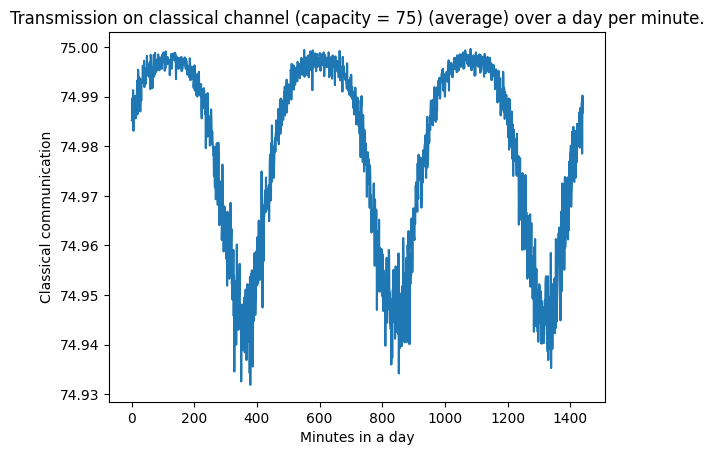

In [ ]:
plt.plot(t, class_comm_mean)
plt.title('Transmission on classical channel (capacity = 75) (average) over a day per minute.')  # Title of the plot
plt.xlabel('Minutes in a day')  # Label for x-axis
plt.ylabel('Classical communication')  # Label for y-axis

plt.savefig('class_comm_1.png', dpi=300) #save as png for high resolution
#plt.legend()  # Show legend
plt.show()
# transmission on classical channel (capacity = 75)

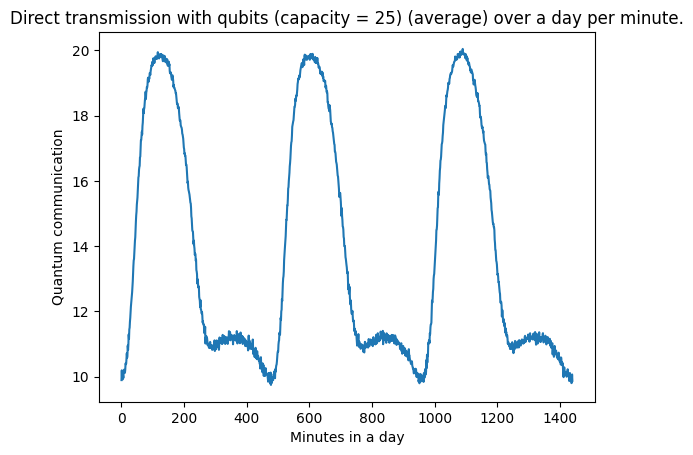

In [ ]:
plt.plot(t, quant_comm_mean)
plt.title('Direct transmission with qubits (capacity = 25) (average) over a day per minute.')  # Title of the plot
plt.xlabel('Minutes in a day')  # Label for x-axis
plt.ylabel('Quantum communication')  # Label for y-axis

plt.savefig('quant_comm_mean_1.png', dpi=300) #save as png for high resolution
#plt.legend()  # Show legend
plt.show()
# direct transmission with qubits (capacity = 30)

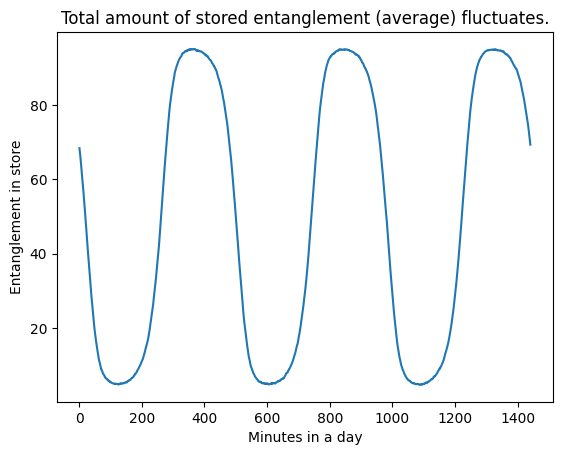

In [ ]:
plt.plot(t, ent_store_mean)
plt.title('Total amount of stored entanglement (average) fluctuates.')  # Title of the plot
plt.xlabel('Minutes in a day')  # Label for x-axis
plt.ylabel('Entanglement in store')  # Label for y-axis

plt.savefig('ent_store_mean_1.png', dpi=300) #save as png for high resolution
#plt.legend()  # Show legend
plt.show()


#total amount stored entanglement reduced (consumend) during peak hours.
#total amount stored entanglement increased (stored) during off hours

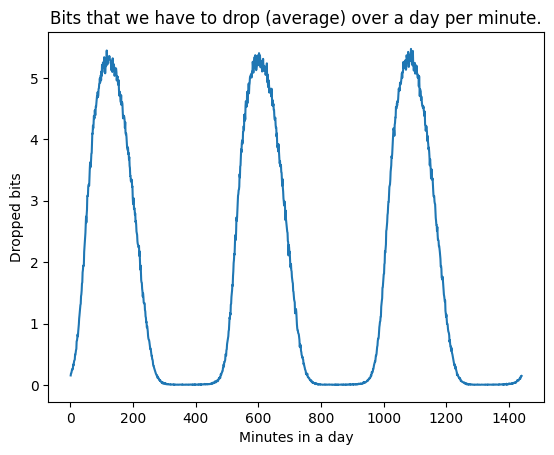

In [ ]:
plt.plot(t, dropp_mean)
plt.title('Bits that we have to drop (average) over a day per minute.')  # Title of the plot
plt.xlabel('Minutes in a day')  # Label for x-axis
plt.ylabel('Dropped bits')  # Label for y-axis

plt.savefig('dropp_mean_1.png', dpi=300) #save as png for high resolution
#plt.legend()  # Show legend
plt.show()

#when trafic demand is high-dropped bits are also increased
#when trafic demand is low-dropped bits are also decreased

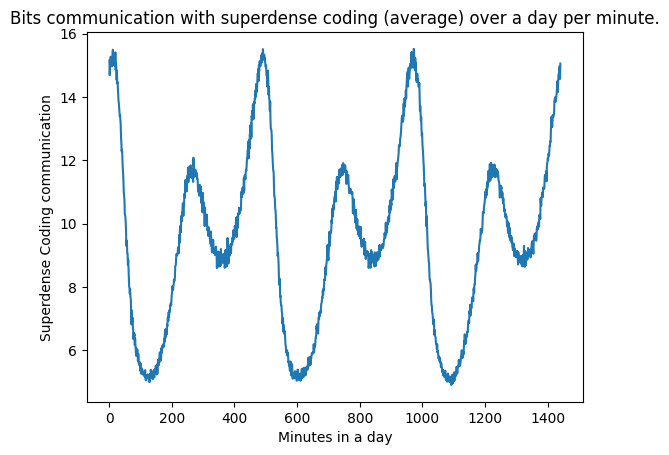

In [ ]:
plt.plot(t, sdc_mean)
plt.title('Bits communication with superdense coding (average) over a day per minute.')  # Title of the plot
plt.xlabel('Minutes in a day')  # Label for x-axis
plt.ylabel('Superdense Coding communication')  # Label for y-axis

plt.savefig('sdc_mean_1.png', dpi=300) #save as png for high resolution
#plt.legend()  # Show legend
plt.show()
#sdc is consumed (lower dip) when Traffic demand is high
#sdc is less consumed (higher dip) when Trafic demand is low

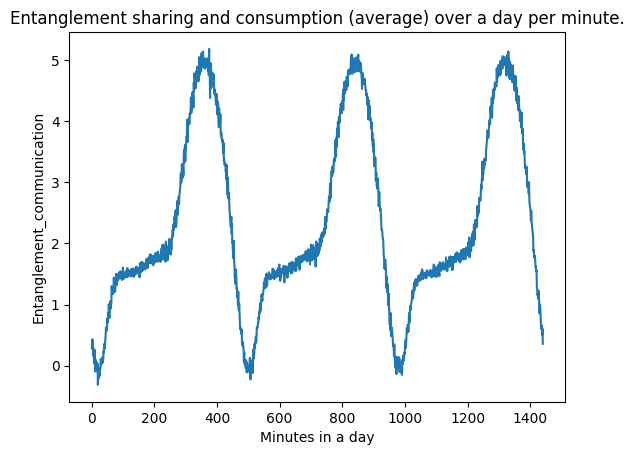

In [ ]:
plt.plot(t, ent_comm_mean)
plt.title('Entanglement sharing and consumption (average) over a day per minute.')  # Title of the plot
plt.xlabel('Minutes in a day')  # Label for x-axis
plt.ylabel('Entanglement_communication')  # Label for y-axis

plt.savefig('ent_comm_mean_1.png', dpi=300) #save as png for high resolution
#plt.legend()  # Show legend
plt.show()
# +ve = entanglement sharing, -ve = entanglement consumed due to SDC.
# But here there no -ve values so no SDC

In [ ]:
data_out = np.array([t, traff_mean, traff_std, class_comm_mean, class_comm_std, quant_comm_mean, quant_comm_std,\
                    ent_store_mean, ent_store_std, dropp_mean, dropp_std, sdc_mean, sdc_std, ent_comm_mean, \
                    ent_comm_std]).T

In [ ]:
fname = 'sdc_data_C_' + str(C) + '_Q_' + str(Q) + '_mem_' + str(mem_capacity) + '_init_' + str(0) + '.csv'
np.savetxt(fname, data_out, delimiter = ',')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
